# 0.0. IMPORTAÇÕES

In [1]:
import os
import pickle
import psycopg2
import warnings

import numpy      as np
import pandas     as pd
import scikitplot as skplt
import seaborn    as sns
import xgboost    as xgb

from boruta                  import BorutaPy
from imblearn.over_sampling  import SMOTE
from sklearn.metrics         import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree            import DecisionTreeClassifier
from tabulate                import tabulate

from matplotlib import pyplot          as plt
from scipy      import stats           as ss
from sklearn    import linear_model    as lm
from sklearn    import metrics         as mt
from sklearn    import model_selection as ms
from sklearn    import neighbors       as nh
from sklearn    import preprocessing   as pp
from sklearn    import ensemble        as en

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

## 0.1. Funções auxiliares

In [2]:
# função de cramer para verificar correlação entre atributos categóricos
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, (chi2/n) - (((k-1)*(r-1))/(n-1)))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / min(kcorr-1, rcorr-1))

# cálculo da precisão no rank k
def precision_at_k(data, k=20000):
    # resetando index
    data = data.reset_index(drop=True)

    # criar ranking
    data['ranking'] = data.index + 1

    # calculando a precisão no k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

# cálculo da recall no rank k
def recall_at_k(data, k=20000):
    # resetando index
    data = data.reset_index(drop=True)

    # criar ranking
    data['ranking'] = data.index + 1

    # calculando a precisão no k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

# cálculo da f1-score no rank k
def f1_at_k(data, k=20000, n=2):
    precision = precision_at_k(data, k=k)
    recall = recall_at_k(data, k=k)
    
    f1_score = n * (precision * recall) / (precision + recall)
    
    return f1_score, precision, recall

# cálculo AUC-ROC
def auc_roc(y, y_pred):
    auc_roc = roc_auc_score(y, y_pred)
    return auc_roc

# validação cruzada
def cross_validation(model, X, y, num_folds=5, k=20000):
    kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    precisions = []
    recalls = []
    f1_scores = []

    for train_ix, val_ix in kfold.split(X, y):
        # separando os dados
        x_train_fold = X.iloc[train_ix]
        y_train_fold = y.iloc[train_ix]

        x_val_fold = X.iloc[val_ix]
        y_val_fold = y.iloc[val_ix]

        # treinamento
        model.fit(x_train_fold, y_train_fold)

        # predição
        yhat = model.predict_proba(x_val_fold)

        # criando dataframe para análise das métricas
        # copia do dataframe
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()

        # copia predicao
        data['score'] = yhat[:, 1].tolist()

        # ordenamento dos clientes pela predicao
        data = data.sort_values('score', ascending=False)

        # métricas
        f1, precision, recall = f1_at_k(data, k)

        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        
    return f1_scores, precisions, recalls

## 0.2. Coletando os dados

In [3]:
df_raw = pd.read_csv('../datasets/train.csv')

# 1.0 DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Descrição das Colunas

**Descrição das colunas do DataFrame de treino.**

|Variável|Definição|
|:------|:------|
|id|Id único por cliente|
|Gender|Gênero do cliente|
|Age|Idade do cliente|
|Driving_License|0: O cliente não possui;<br> 1: O cliente já possui|
|Region_Code|Código exclusivo da região do cliente|
|Previously_Insured|0: Cliente não tem seguro de carro; <br>1: Cliente já possui seguro de carro|
|Vehicle_Age|Idade do veículo|
|Vehicle_Damage|0: O cliente não teve seu veículo danificado no passado; <br>1: O cliente já teve seu veículo danificado no passado|
|Annual_Premium|Quantidade que o cliente pagou à empresa pelo seguro de saúde anual.|
|Policy_Sales_Channel|Código anônimo para o canal de contato com o cliente, ou seja: Agentes diferentes, por Correios, por telefone, pessoalmente, etc|
|Vintage|Número de dias que o cliente foi associado à empresa|
|Response|0: O cliente não está interessado; <br>1: O cliente está interessado|

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 
            'annual_premium', 'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.2. Dimensão dos Dados

In [6]:
print('Há {} linhas no Dataset'.format(df1.shape[0]))
print('Há {} colunas no Dataset'.format(df1.shape[1]))

Há 381109 linhas no Dataset
Há 12 colunas no Dataset


## 1.3. Tipo dos Dados

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Verificando NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Estatística Descritiva

In [9]:
num_attributes = df1[['id', 'age', 'region_code', 'annual_premium', 'policy_sales_channel', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'response']]

### 1.5.1. Atributos Numéricos

In [10]:
# Métricas de Tendência Central
mean   = pd.DataFrame(num_attributes.apply(np.mean))
median = pd.DataFrame(num_attributes.apply(np.median))

# Métricas de dispersão dos dados
std = pd.DataFrame(num_attributes.apply(np.std))
min_ = pd.DataFrame(num_attributes.apply(min))
max_ = pd.DataFrame(num_attributes.apply(max))
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

# Métricas
m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis], axis=1).reset_index()
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std',' skew', 'kurtosis']
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,381109.000,381108.000,190555.000,190555.000,110016.692,0.000,-1.200
1,age,20.000,85.000,65.000,38.823,36.000,15.512,0.673,-0.566
2,region_code,0.000,52.000,52.000,26.389,28.000,13.230,-0.115,-0.868
3,annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,17213.132,1.766,34.005
4,policy_sales_channel,1.000,163.000,162.000,112.034,133.000,54.204,-0.900,-0.971
5,vintage,10.000,299.000,289.000,154.347,154.000,83.671,0.003,-1.201


### 1.5.2. Atributos Categóricos

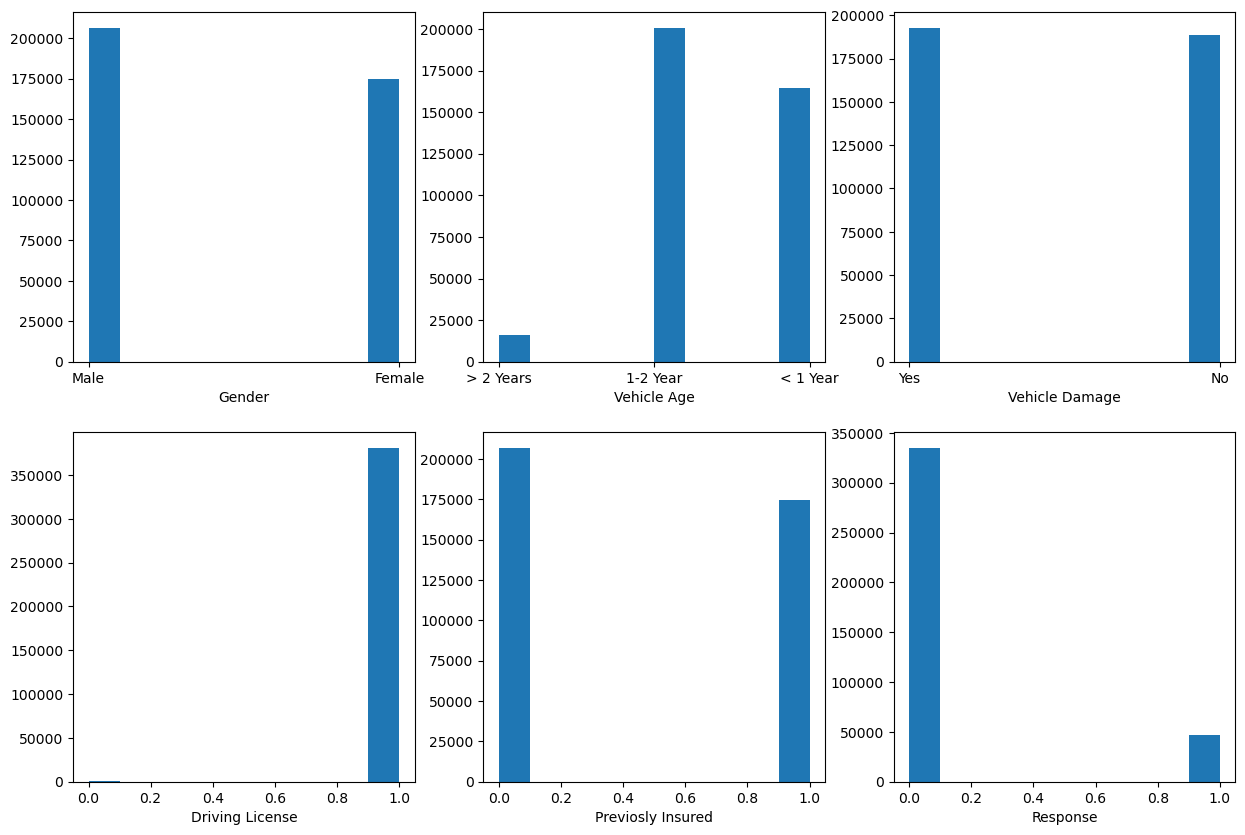

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axs[0, 0].hist(cat_attributes.gender); # gender
axs[0, 0].set_xlabel('Gender');
axs[0, 1].hist(cat_attributes.vehicle_age); # vehicle_age
axs[0, 1].set_xlabel('Vehicle Age');
axs[0, 2].hist(cat_attributes.vehicle_damage); # vehicle_damage
axs[0, 2].set_xlabel('Vehicle Damage');
axs[1, 0].hist(cat_attributes.driving_license);
axs[1, 0].set_xlabel('Driving License');
axs[1, 1].hist(cat_attributes.previously_insured);
axs[1, 1].set_xlabel('Previosly Insured')
axs[1, 2].hist(cat_attributes.response);
axs[1, 2].set_xlabel('Response');

# 2.0 FEATURE ENGINEERING

In [12]:
df2 = df1.copy()

In [13]:
# vehicle_age
vehicle_age = {'< 1 Year': 'below_1_year', '1-2 Year': 'between_1_2_year', '> 2 Years': 'over_2_years'}
df2['vehicle_age'] = df2['vehicle_age'].map(vehicle_age)

# 3.0. FILTRAGEM DAS VARIÁVEIS

In [14]:
df3 = df2.copy()

Neste primeiro ciclo CRISP não removeremos nenhuma linha ou feature

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [15]:
df4 = df3.copy()

## 4.1. Análise Univariada

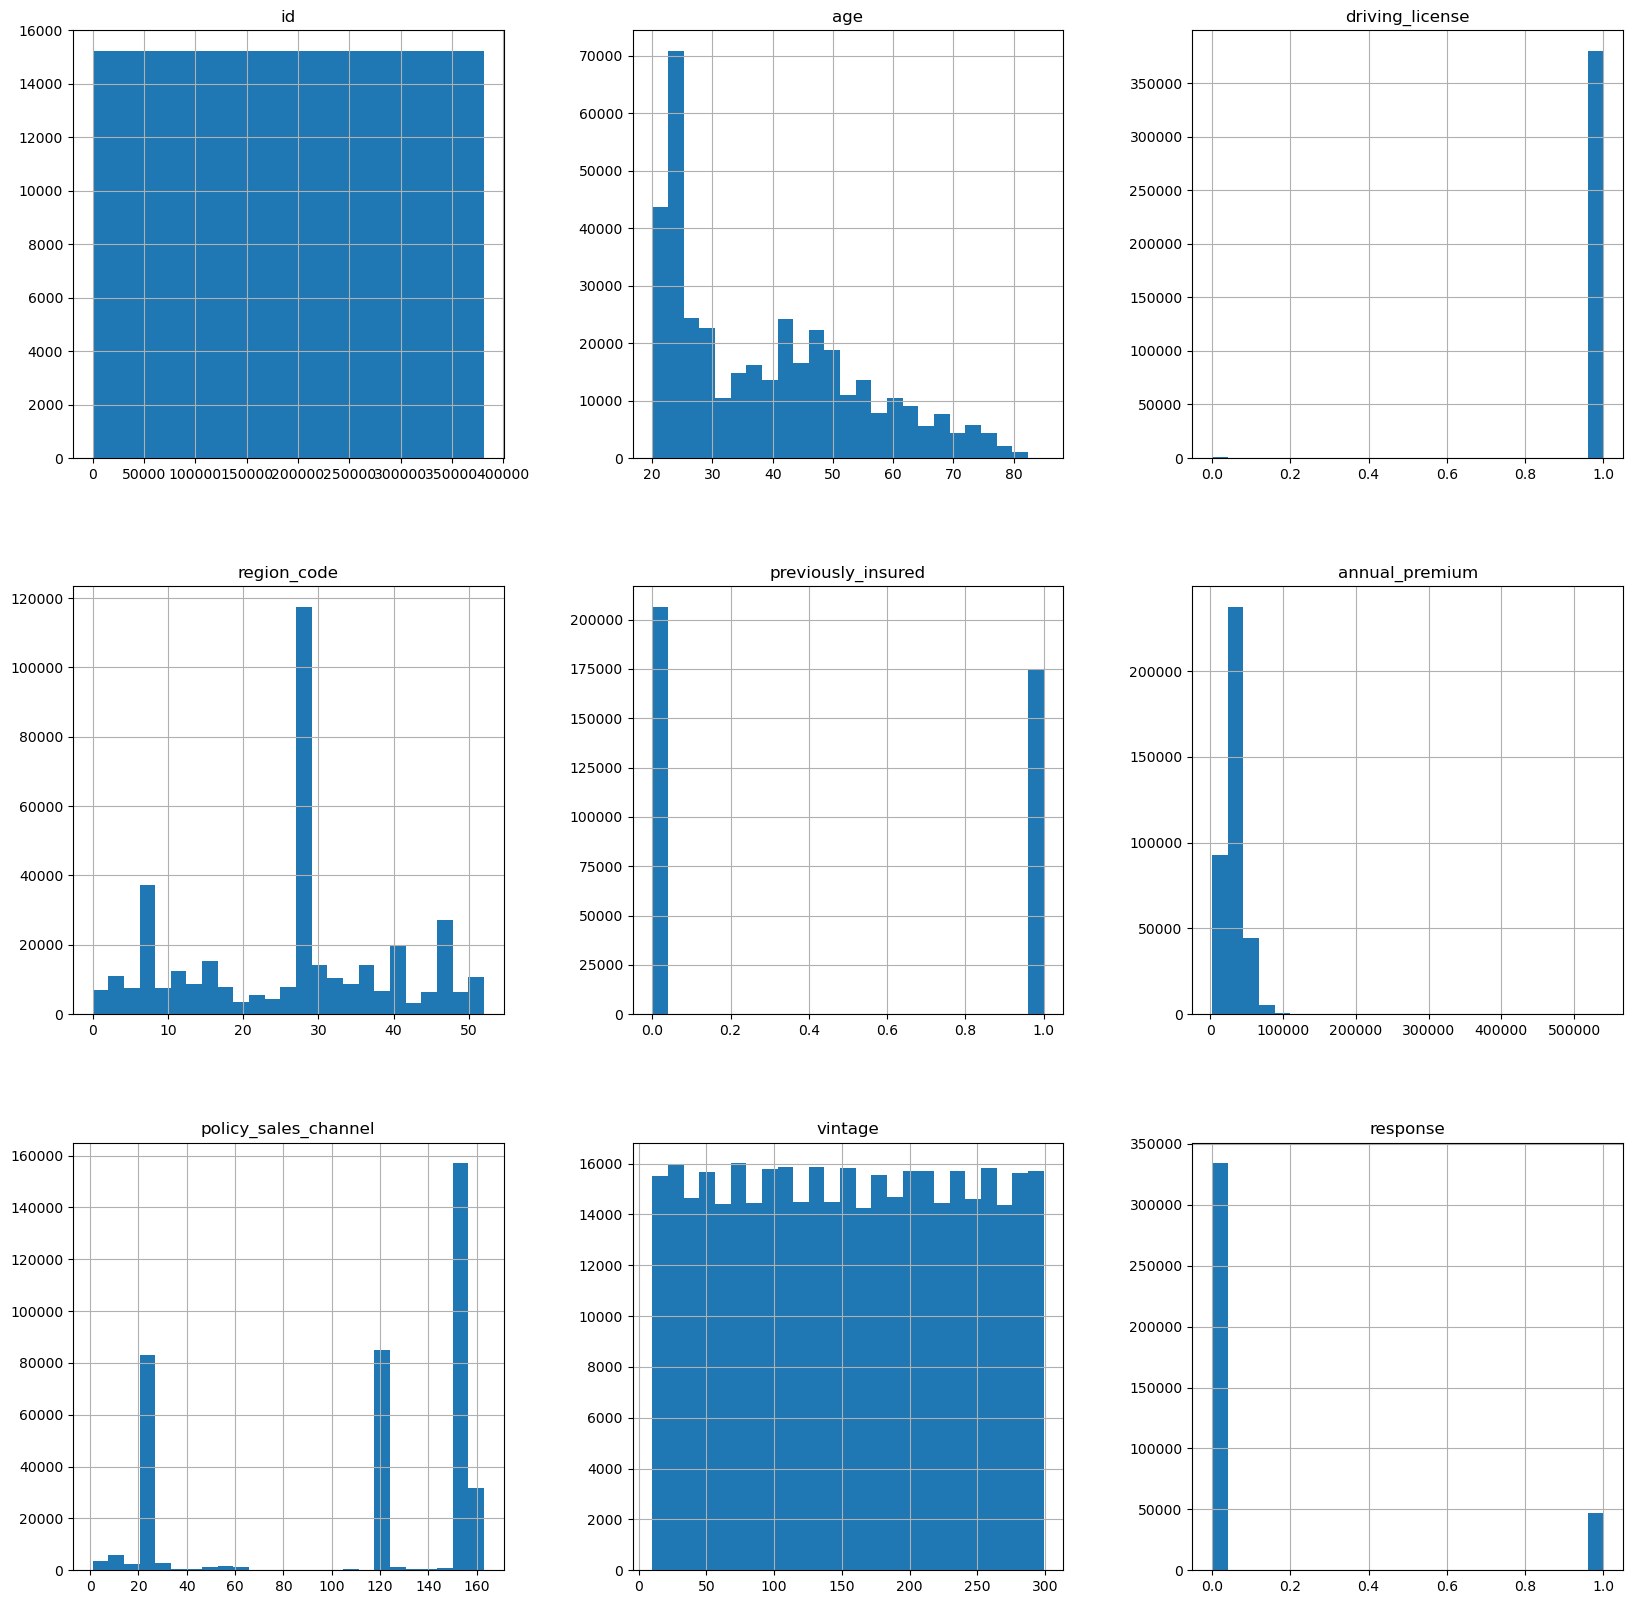

In [16]:
fig = plt.figure(figsize=(20, 20))

df4.hist(bins=25, ax=fig.gca());

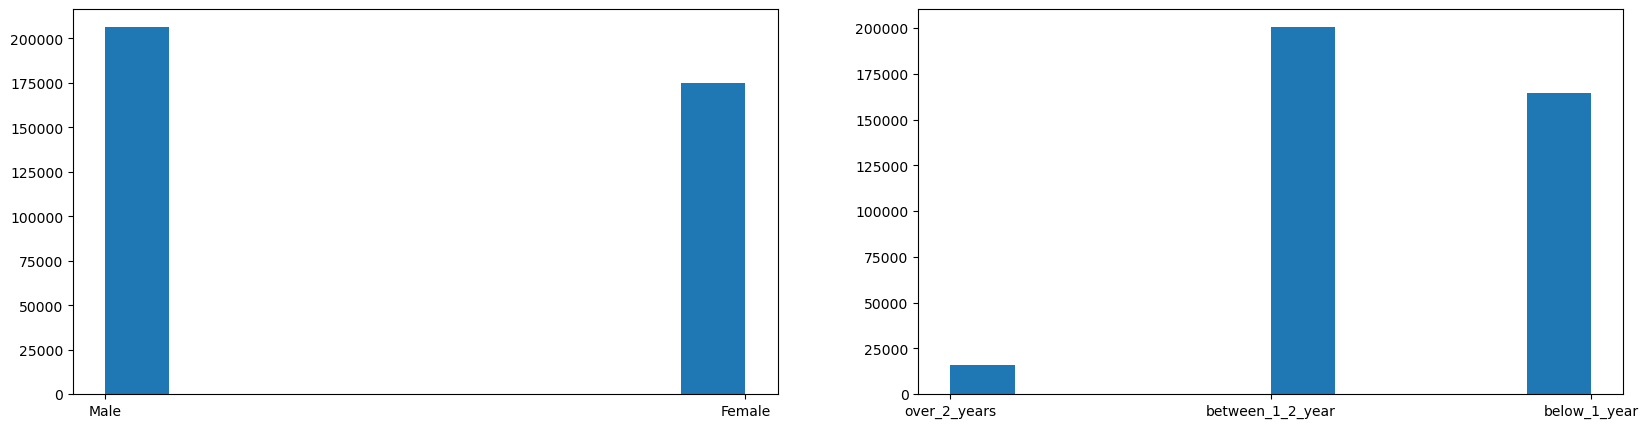

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5));
axs[0].hist(x='gender', data=df4);
axs[1].hist(x='vehicle_age', data=df4);

## 4.2. Análise Bivariada

### 4.2.1. Criação de Hipóteses

H1. Pessoas mais velhas tem mais interesse no seguro de carro.

H2. Pessoas que já tem seguro tem menos interesse no seguro oferecido.

H3. Pessoas que já tiveram o carro danificado tem mais interesse no seguro.

H4. Pessoas com o valor do prêmio anual menor tem mais interesse.

H5. Pessoas com mais tempo de associado tem mais interesse no seguro de carro.

H6. A região não faz diferença no interesse das pessoas pelo seguro.

H7. O canal de contato não faz diferença no interesse das pessoas pelo seguro.

H8. Mulheres tem mais interesse no seguro.

H9. Pessoas com carros mais novos tem mais interesse no seguro.

### 4.2.2. Validação das Hipóteses

#### H1. Pessoas com mais de 30 anos tem mais interesse no seguro de carro.
**Verdadeira.** Vemos um aumento na quantidade de interessados e uma maior porcentagem de interessados por idade.

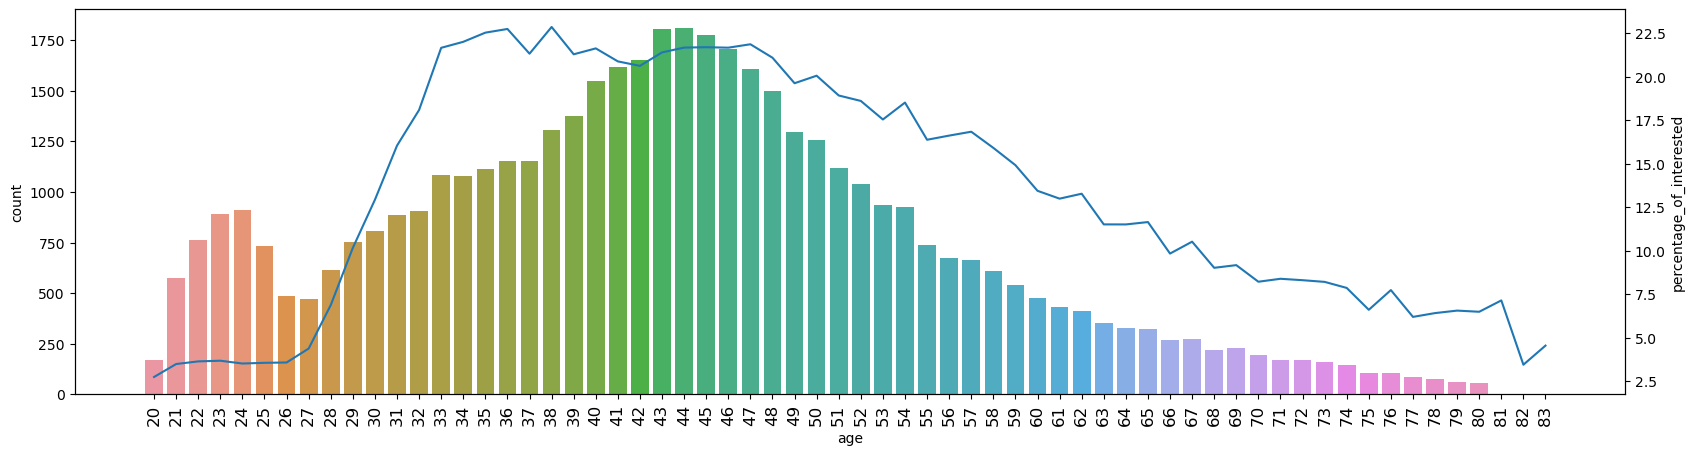

In [18]:
aux = df4[['age', 'id', 'response']].groupby(['age', 'response']).count().reset_index().rename(columns={'id': 'count'})
aux['percentage_of_interested'] = aux.groupby('age')['count'].apply(lambda x: x.div(x.sum())*100)
aux = aux[aux['response'] == 1]

fig, axs = plt.subplots(figsize=(20, 5))

# plotar gráfico de barras
sns.barplot(x='age', y='count', data=aux, ax=axs);

# criar segundo eixo y
ax2= plt.twinx()

# plotar gráfico de linha
sns.lineplot(x=aux['age'].astype(str), y='percentage_of_interested', data=aux, ax=ax2);

# rotacionar texto eixo x
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, fontsize=12);

#### H2. Pessoas que já têm seguro têm menos interesse no seguro oferecido.
**Verdadeira.** Quase nenhuma pessoa com seguro tem interesse no seguro oferecido.

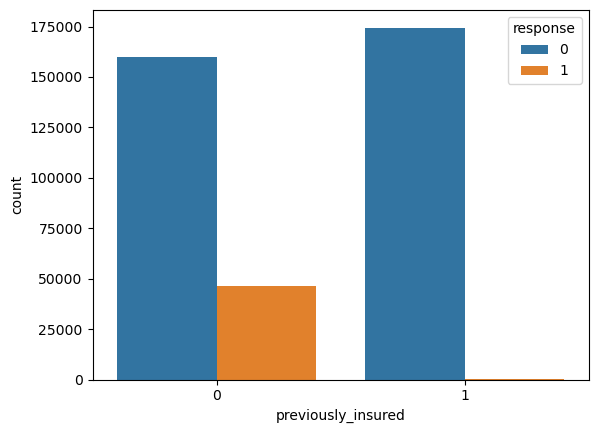

In [19]:
aux = df4[['previously_insured', 'response', 'id']].groupby(['previously_insured', 'response']).count().reset_index().rename(columns={'id': 'count'})

sns.barplot(x='previously_insured', y='count', hue='response', data=aux);

#### H3. Pessoas que já tiveram o carro danificado tem mais interesse no seguro.
**Verdadeira.** A grande maioria dos interessados teve o carro danificado.

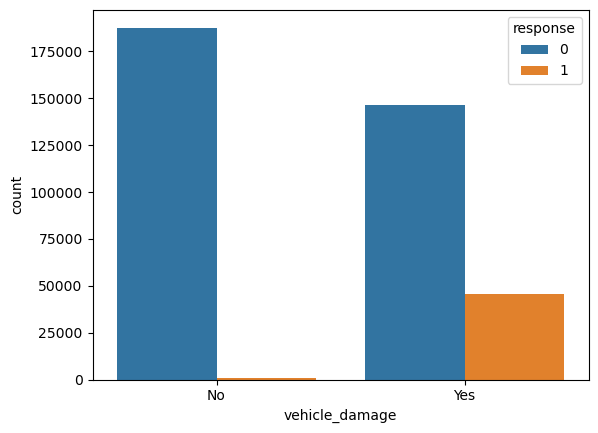

In [20]:
aux = df4[['vehicle_damage', 'response', 'id']].groupby(['vehicle_damage', 'response']).count().reset_index().rename(columns={'id': 'count'})

sns.barplot(x='vehicle_damage', y='count', hue='response', data=aux);

#### H4. Pessoas com o valor do prêmio anual menor tem mais interesse.
**Falsa.** O maior número de interessados está no intervalo de 30.000 a 40.000 reais de prêmio anual.

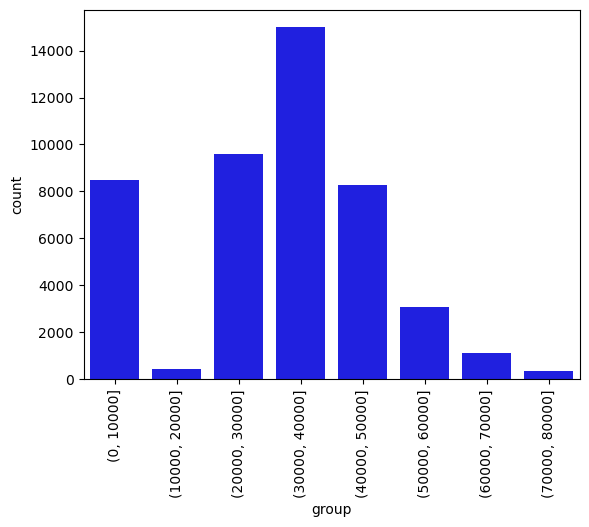

In [21]:
aux = df4[df4['response'] == 1][['annual_premium']]

# criando os intervalos de valores
ranges = range(0, 550000, 10000)

# criando feature 'group' com o intervalo
aux['group'] = pd.cut(aux['annual_premium'], bins=ranges).astype(str)

# contando cada 'group'
aux = aux.groupby('group').count().reset_index().rename(columns={'annual_premium': 'count'})

# selecionando grupos com mais de 300 clientes
aux = aux[aux['count'] >= 300].reset_index(drop=True)

ax = sns.barplot(x=aux['group'], y=aux['count'], color='blue');
ax.set_xticklabels(aux['group'], rotation=90);

#### H5. Pessoas com mais tempo de associado tem mais interesse no seguro de carro.
**Falsa.** Observa-se uma quantidade de interessados constante, independente do tempo de associado.

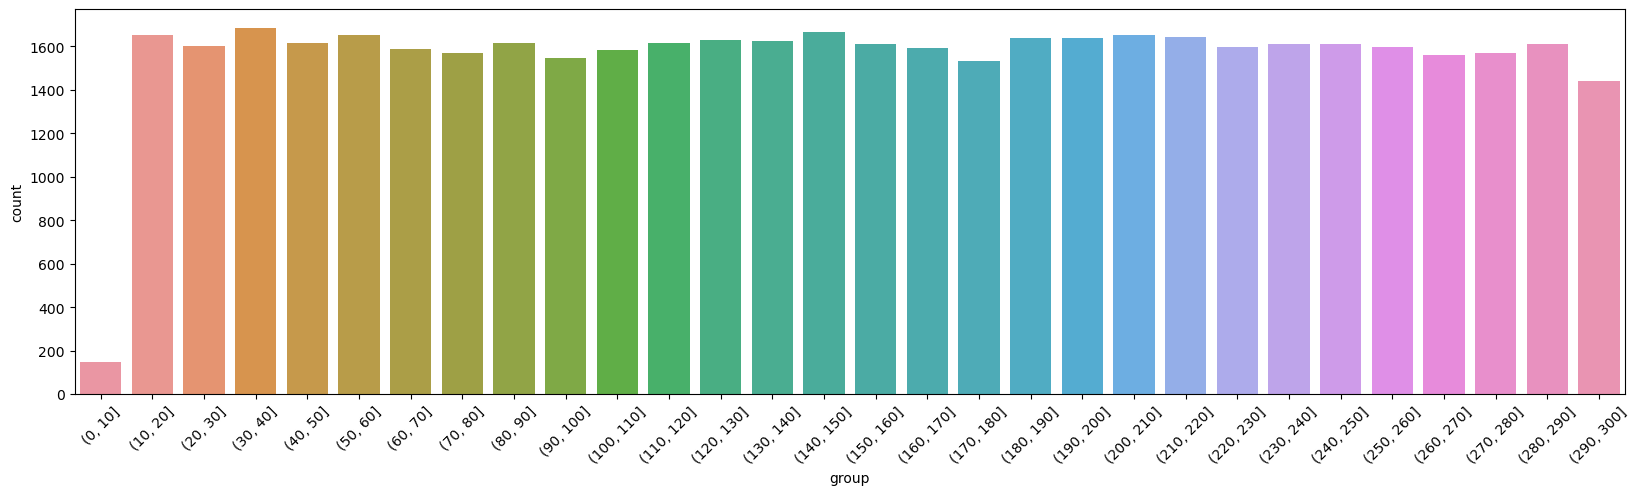

In [22]:
aux = df4[df4['response'] == 1]
aux = aux[['vintage', 'response']].groupby('vintage').count().reset_index().rename(columns={'response': 'count'})

# intervalos de tempo
ranges = range(0, 310, 10)

# adicionando grupo do intervalo de tempo
aux['group'] = pd.cut(aux['vintage'], bins=ranges)

# somando contagens
aux = aux.groupby('group').sum('count').sort_values('group').reset_index()

plt.figure(figsize=(20, 5))

# plotar gráfico de barras
ax = sns.barplot(x='group', y='count', data=aux);
ax.set_xticklabels(aux['group'], rotation=45);

#### H6. A região faz diferença no interesse das pessoas pelo seguro.
**Falsa.** Quantitativamente observa-se uma diferença, principalmente para a região 28, porém ao observar a proporção de interessados por região, nota-se que não há grande diferença de interessados por região.

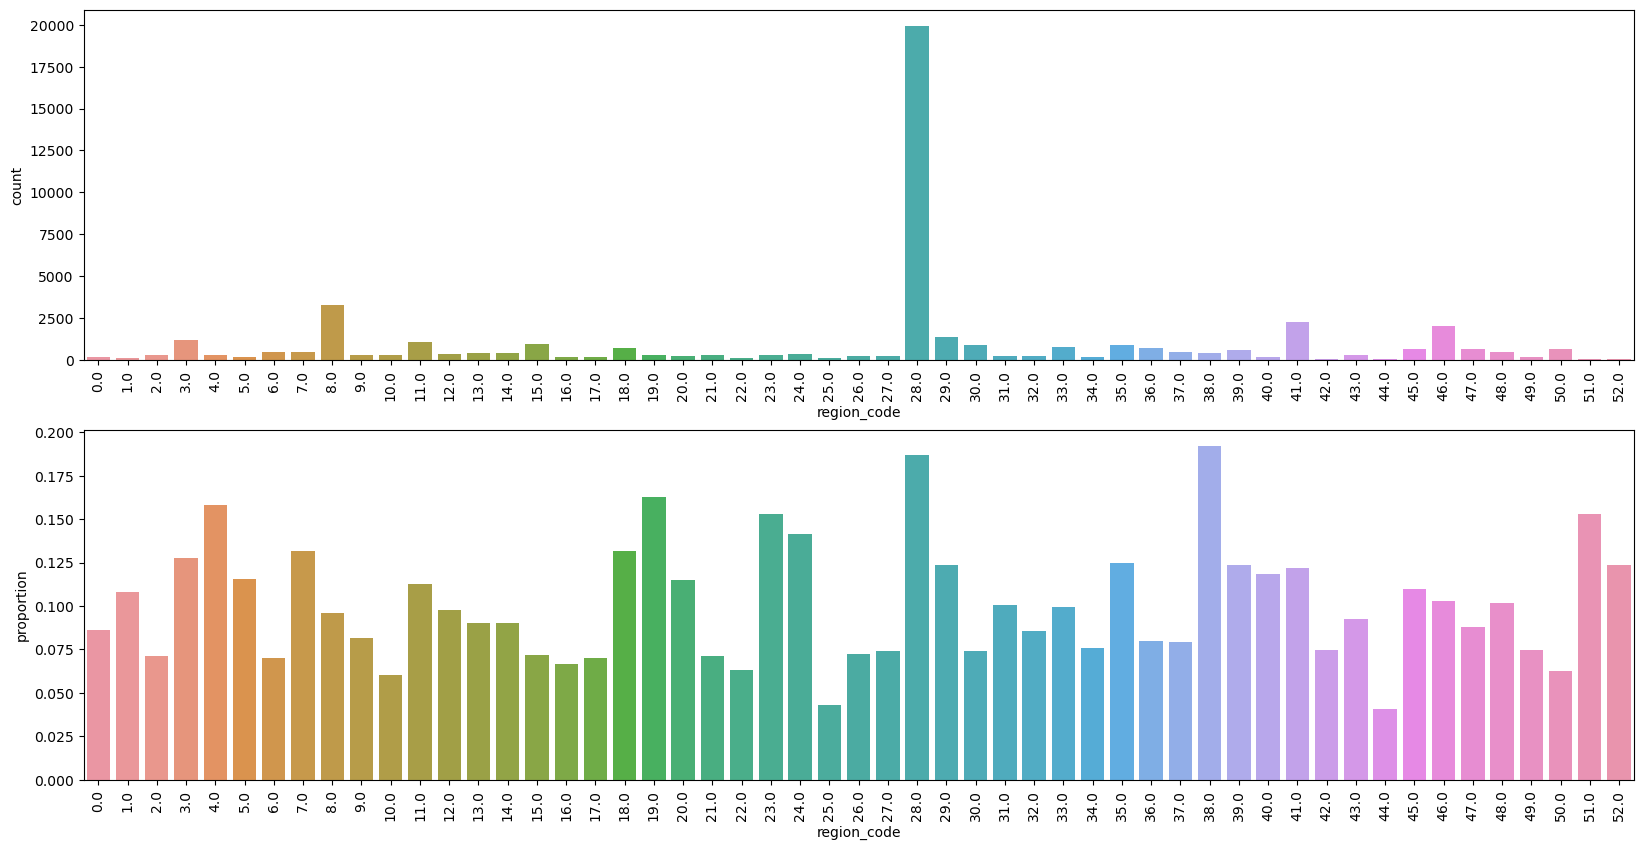

In [23]:
# quantidade de interessados por região
aux = df4[['region_code', 'response']].groupby('region_code').value_counts().reset_index().rename(columns={0: 'count'})
aux = aux.loc[aux['response'] == 1, :]

# proporção de interessados por região
aux2 = df4[['region_code', 'response']].groupby('region_code').value_counts(normalize=True).reset_index().rename(columns={0: 'proportion'})
aux2 = aux2.loc[aux2['response'] == 1, :]

# gráfico
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# plotar
sns.barplot(x='region_code', y='count', data=aux, ax=axs[0]); # contagem
sns.barplot(x='region_code', y='proportion', data=aux2, ax=axs[1]); # proporção

for ax in axs: ax.set_xticklabels(aux['region_code'], rotation=90);

#### H7. O canal de contato faz diferença no interesse das pessoas pelo seguro.
**Falsa.** Não aparenta haver relação entre canal de contato com a taxa de interessados no seguro.

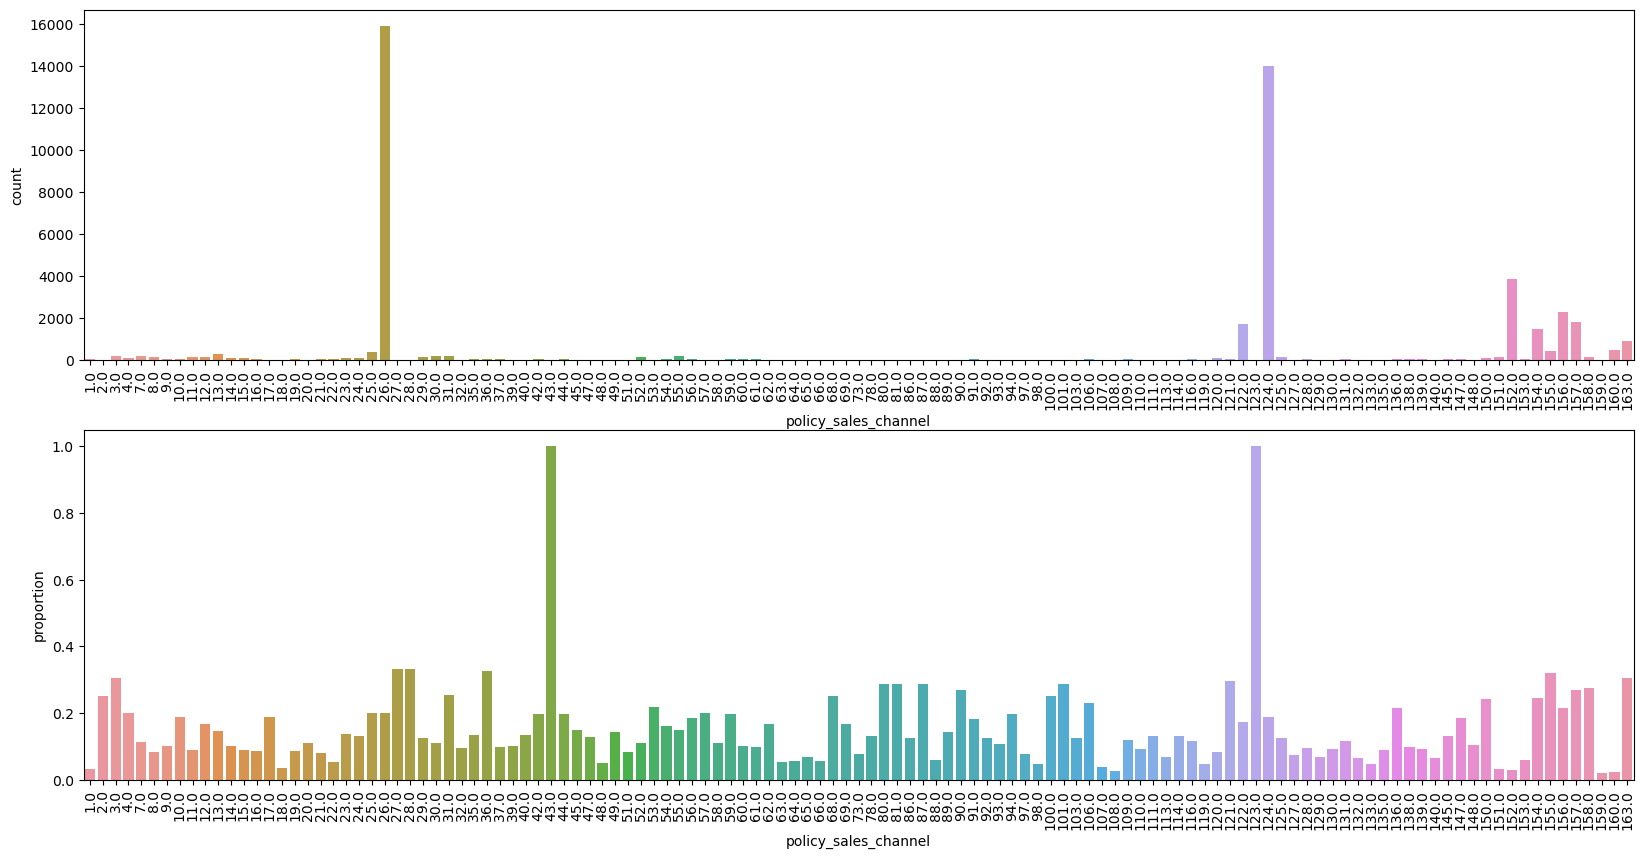

In [24]:
# quantidade de interessados por região
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').value_counts().reset_index().rename(columns={0: 'count'})
aux = aux.loc[aux['response'] == 1, :]

# proporção de interessados por região
aux2 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').value_counts(normalize=True).reset_index().rename(columns={0: 'proportion'})
aux2 = aux2.loc[aux2['response'] == 1, :]

# gráfico
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# plotar
sns.barplot(x='policy_sales_channel', y='count', data=aux, ax=axs[0]); # contagem
sns.barplot(x='policy_sales_channel', y='proportion', data=aux2, ax=axs[1]); # proporção

for ax in axs: ax.set_xticklabels(aux['policy_sales_channel'], rotation=90);

In [25]:
aux[aux['policy_sales_channel'] == 43.0]

,policy_sales_channel,response,count
77,43.000,1,1


#### H8. Mulheres tem mais interesse no seguro do que os homens.
**Falsa.** Há uma taxa maior de homens interessados no seguro.

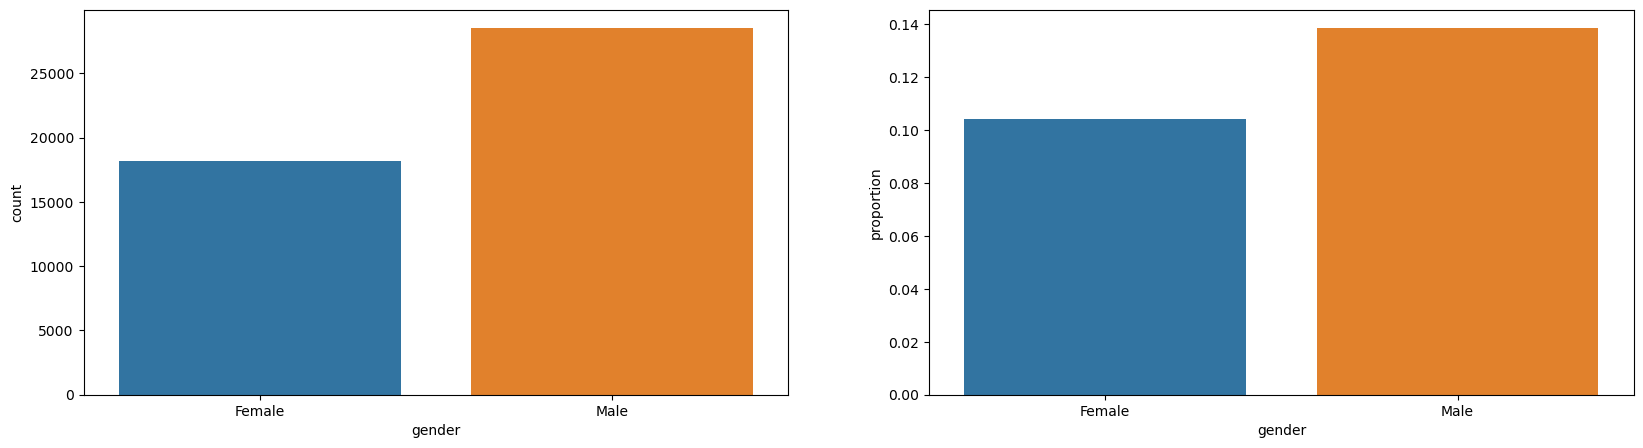

In [26]:
# quantitativo
aux = df4[['gender', 'response']].groupby('gender').value_counts().reset_index().rename(columns={0: 'count'})
aux = aux[aux['response'] == 1]

# proporção
aux2 = df4[['gender', 'response']].groupby('gender').value_counts(normalize=True).reset_index().rename(columns={0: 'proportion'})
aux2 = aux2[aux2['response'] == 1]

# gráfico
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# plotar
sns.barplot(x='gender', y='count', data=aux, ax=axs[0]);
sns.barplot(x='gender', y='proportion', data=aux2, ax=axs[1]);

#### H9. Pessoas com carros mais novos tem mais interesse no seguro.
**Falsa.** Ao contrário, observa-se que quão mais velho o veículo, maior a taxa de interessados.

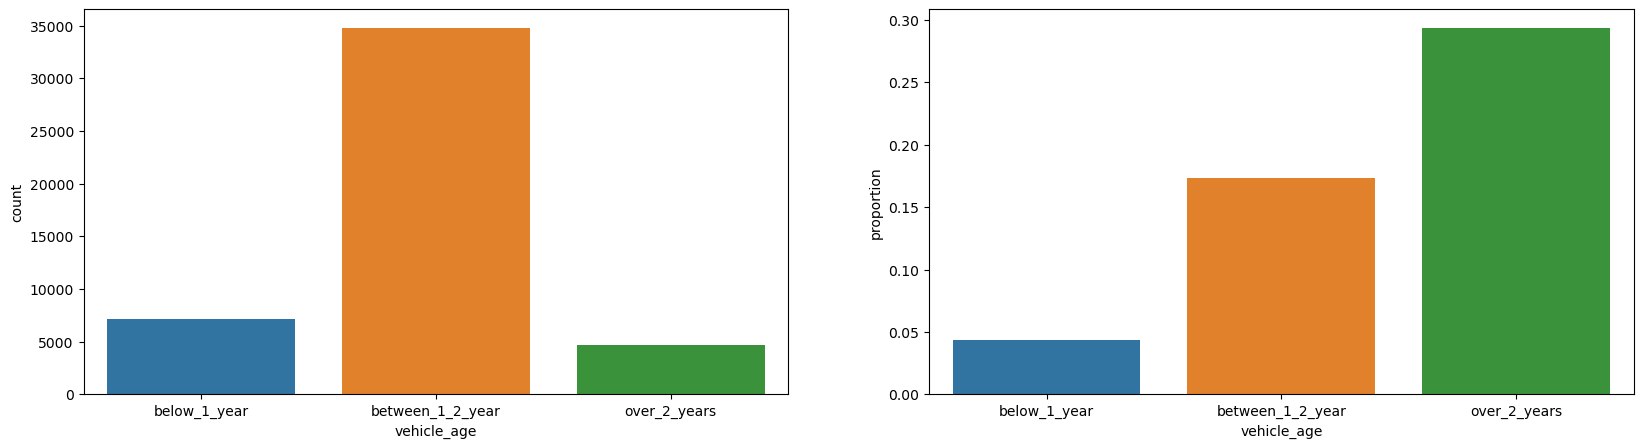

In [27]:
# quantitativo
aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').value_counts().reset_index().rename(columns={0: 'count'})
aux = aux[aux['response'] == 1]

# proporção
aux2 = df4[['vehicle_age', 'response']].groupby('vehicle_age').value_counts(normalize=True).reset_index().rename(columns={0: 'proportion'})
aux2 = aux2[aux2['response'] == 1]

# gráfico
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# plotar
sns.barplot(x='vehicle_age', y='count', data=aux, ax=axs[0]);
sns.barplot(x='vehicle_age', y='proportion', data=aux2, ax=axs[1]);

#### Resumo das Hipóteses

In [28]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Média'],
       ['H2', 'Verdadeira', 'Alta'],
       ['H3', 'Verdadeira', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', 'Falsa', 'Baixa'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Baixa'],
       ['H9', 'Falsa', 'Alta']]

print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Verdadeira   Média
H2          Verdadeira   Alta
H3          Verdadeira   Média
H4          Falsa        Baixa
H5          Falsa        Baixa
H6          Falsa        Baixa
H7          Falsa        Baixa
H8          Falsa        Baixa
H9          Falsa        Alta


## 4.3. Análise Multivariada

In [29]:
# atributos numéricos
num_features = ['age', 'annual_premium', 'vintage', 'response']
num_attributes = df4.loc[:, num_features]

# atributos categóricos
cat_features = ['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 
                'policy_sales_channel', 'response']
cat_attributes = df4.loc[:, cat_features]

### 4.3.1. Atributos Numéricos

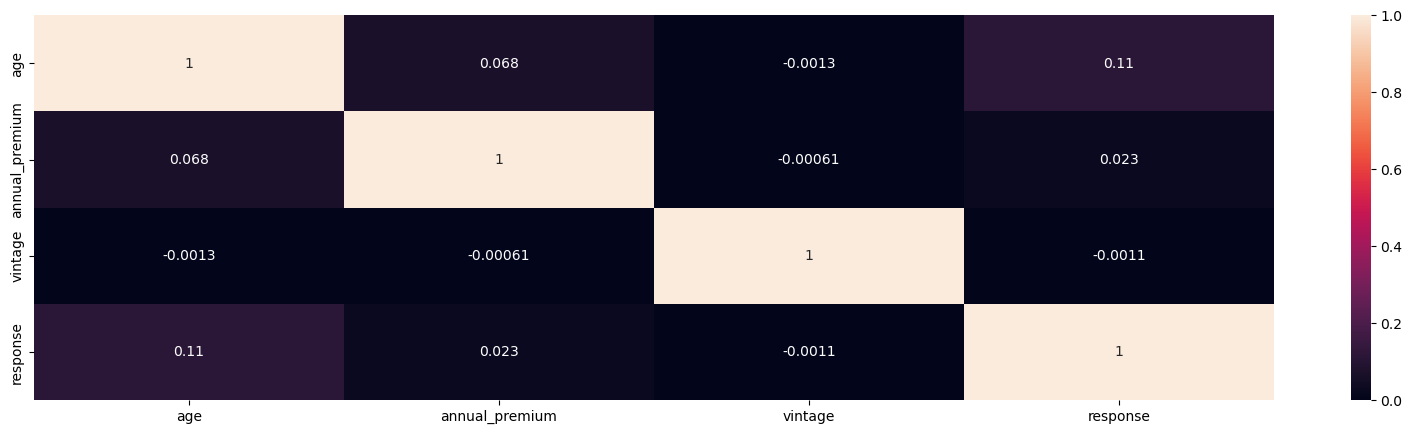

In [30]:
plt.figure(figsize=(20, 5))

corr = num_attributes.corr(method='pearson')

sns.heatmap(corr, annot=True);

### 4.3.2. Atributos Categóricos

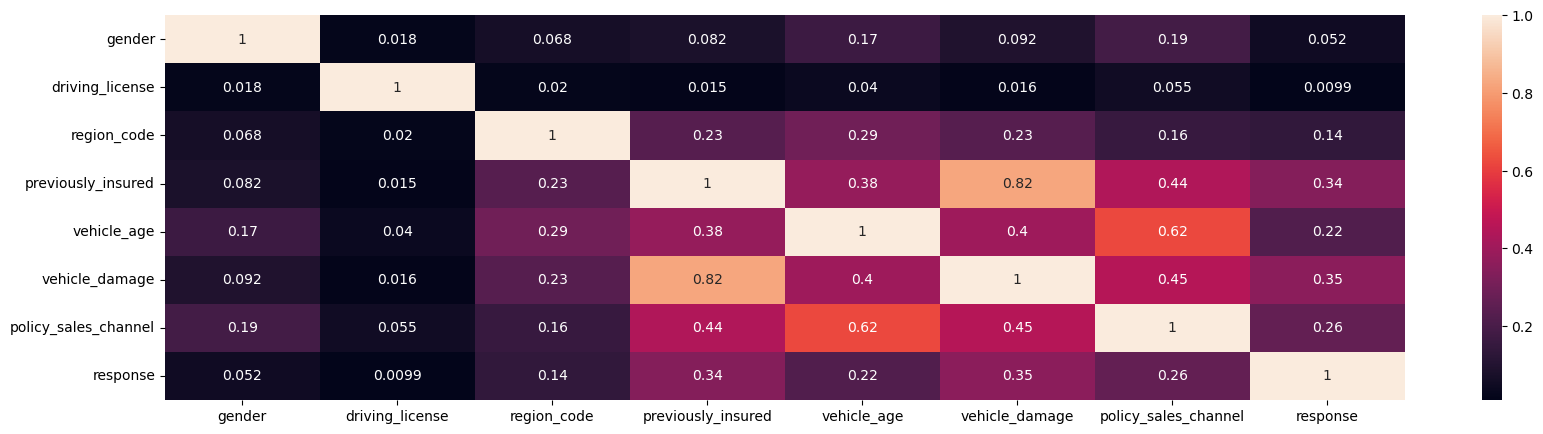

In [31]:
# dataset
d = pd.DataFrame(columns=cat_attributes.columns)

# verificação correlação atributos categóricos
for i in range(cat_attributes.shape[1]):
    for j in range(cat_attributes.shape[1]):                
        d.loc[i, d.columns[j]] = cramer_v(cat_attributes.iloc[:, i], cat_attributes.iloc[:, j])

# nomeando o index com os nomes das colunas
d = d.set_index(d.columns)
# conversão para float
d = d.astype('float64')

# gráfico
plt.figure(figsize=(20, 5))
sns.heatmap(d, annot=True);

# 5.0. PREPARAÇÃO DOS DADOS

In [32]:
# separando dados em treino e teste
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train_validation, x_test, y_train_validation, y_test = ms.train_test_split(X, y, test_size=0.15, stratify=y)

df5 = pd.concat([x_train_validation, y_train_validation], axis=1)

## 5.1. Normalização

In [33]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../webapp/parameter/standard_scaler_annual_premium.pkl', 'wb'))

## 5.2. Redimensionando

In [34]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../webapp/parameter/min_max_scaler_age.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../webapp/parameter/min_max_scaler_vintage.pkl', 'wb'))

## 5.3. Encoder

In [35]:
# region_code - Target Encoding (or Frequency Encoding)
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../webapp/parameter/target_encode_region_code.pkl', 'wb'))

# vehicle_age - One Hot Encoding (or Order Encoding / or Frequency Encoding)
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'], dtype='int64')

# policy_sales_channel - Frequency Encoding (or Target Encoding)
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../webapp/parameter/fe_policy_sales_channel.pkl', 'wb'))

# vehicle_damage - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_damage', columns=['vehicle_damage'], dtype='int64')

# gender - One Hot Encoding (or Target Encoding)
df5 = pd.get_dummies(df5, prefix='gender', columns=['gender'], dtype='int64')

## 5.4. Preparação do Dataset de Teste

In [36]:
# annual_premium
x_test['annual_premium'] = ss.fit_transform(x_test[['annual_premium']].values)

# age
x_test['age'] = mms_age.transform(x_test[['age']].values)

# vintage
x_test['vintage'] = mms_vintage.transform(x_test[['vintage']].values)

# region_code
x_test['region_code'] = x_test['region_code'].map(target_encode_region_code)

# vehicle_age
x_test = pd.get_dummies(x_test, prefix='vehicle_age', columns=['vehicle_age'], dtype='int64')

# vehicle_damage - One Hot Encoding
x_test = pd.get_dummies(x_test, prefix='vehicle_damage', columns=['vehicle_damage'], dtype='int64')

# policy_sales_channel
x_test['policy_sales_channel'] = x_test['policy_sales_channel'].map(fe_policy_sales_channel)

# gender
# x_test['gender'] = x_test['gender'].map(target_encode_gender)
x_test = pd.get_dummies(x_test, prefix='gender', columns=['gender'], dtype='int64')

# fillna
x_test = x_test.fillna(0)

# 6.0. SELEÇÃO DE FEATURES

In [37]:
X = df5.drop('response', axis=1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.15, stratify=y)

df6 = pd.concat([x_train, y_train], axis=1)

## 6.1. Selecionando Features com o ExtraTreesClassifier 

In [38]:
# preparação dos dados
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

# model
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# treinamento modelo
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage       0.268
0                annual_premium       0.241
0                           age       0.175
0                   region_code       0.106
0          policy_sales_channel       0.060
0             vehicle_damage_No       0.045
0            previously_insured       0.043
0            vehicle_damage_Yes       0.041
0      vehicle_age_below_1_year       0.011
0  vehicle_age_between_1_2_year       0.006
0      vehicle_age_over_2_years       0.002
0                   gender_Male       0.001
0                 gender_Female       0.001
0               driving_license       0.000


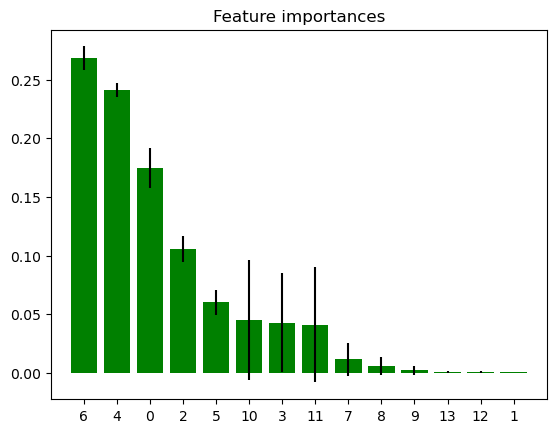

In [39]:
# importância das features
importances = forest.feature_importances_

# desvio padrão das importâncias de cada feature de todas as árvores do modelo
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# ordenando os índices das importâncias
indices = np.argsort(importances)[::-1]

# impressão do rank de features
print('Feature Ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# gráfico
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='g', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. MODELAGEM DO MACHINE LEARNING

In [40]:
# features com maior importância
cols_selected = ['age', 'region_code', 'previously_insured', 'annual_premium', 'policy_sales_channel', 
                 'vintage', 'vehicle_damage_No', 'vehicle_damage_Yes']

x_train = df6[cols_selected]
y_train = y_train.copy()
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

X = X[cols_selected]
y = y.copy()

## 7.1. KNN

,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,KNN,0.261,0.876,0.402


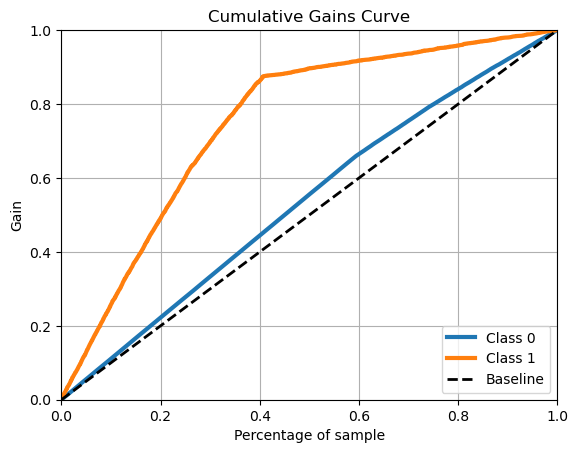

In [41]:
# model
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# treinamento
knn_model.fit(x_train, y_train)

# predição
yhat_knn = knn_model.predict_proba(x_val)

# métricas
# copia do dataframe
data_knn = x_val.copy()
data_knn['response'] = y_val.copy()

# copia predicao KNN
data_knn['score'] = yhat_knn[:, 1].tolist()

# ordenamento dos clientes pela predicao KNN
data_knn = data_knn.sort_values('score', ascending=False)

f1, precision, recall = f1_at_k(data_knn)
result_knn = pd.DataFrame({'model': ['KNN'],
                           'Precision at 20000': precision,
                           'Recall at 20000': recall,
                           'F1-Score at 20000': f1})

# gráfico - ganho acumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

result_knn

### 7.1.1. KNN Cross-Validation

In [42]:
# model
knn_model = nh.KNeighborsClassifier(n_neighbors=7)  

f1_knn, precision_knn, recall_knn = cross_validation(model=knn_model, X=X, y=y)

result_knn_cv = pd.DataFrame({'model': ['KNN'],
                           'Precision_CV at 20000': np.mean(precision_knn),
                           'Recall_CV at 20000': np.mean(recall_knn),
                           'F1-Score_CV at 20000': np.mean(f1_knn)})
result_knn_cv

,model,Precision_CV at 20000,Recall_CV at 20000,F1-Score_CV at 20000
0,KNN,0.279,0.703,0.399


## 7.2. Logistic Regression

,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,Logistic Regression,0.264,0.887,0.407


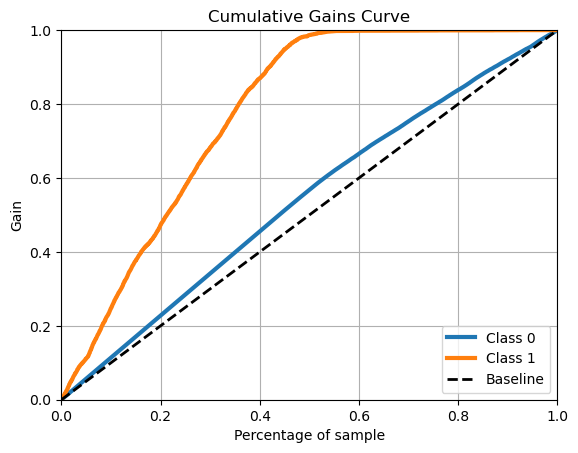

In [43]:
# model
lr_model = lm.LogisticRegression(random_state=42)

# treinamento
lr_model.fit(x_train, y_train)

# predição
yhat_lr = lr_model.predict_proba(x_val)

# métricas
# copia do dataframe
data_lr = x_val.copy()
data_lr['response'] = y_val.copy()

# copia predicao
data_lr['score'] = yhat_lr[:, 1].tolist()

# ordenamento dos clientes pela predicao
data_lr = data_lr.sort_values('score', ascending=False)

f1, precision, recall = f1_at_k(data_lr)
result_lr = pd.DataFrame({'model': ['Logistic Regression'],
                           'Precision at 20000': precision,
                           'Recall at 20000': recall,
                           'F1-Score at 20000': f1})

# gráfico - ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

result_lr

### 7.2.1. Logistic Regression Cross-Validation

In [44]:
# model
lr_model = lm.LogisticRegression(random_state=42)

f1_lr, precision_lr, recall_lr = cross_validation(model=lr_model, X=X, y=y)

result_lr_cv = pd.DataFrame({'model': ['Logistic Regression'],
                           'Precision_CV at 20000': np.mean(precision_lr),
                           'Recall_CV at 20000': np.mean(recall_lr),
                           'F1-Score_CV at 20000': np.mean(f1_lr)})
result_lr_cv

,model,Precision_CV at 20000,Recall_CV at 20000,F1-Score_CV at 20000
0,Logistic Regression,0.279,0.702,0.399


## 7.3. Random Forest Classifier

,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,Random Forest Classifier,0.269,0.904,0.415


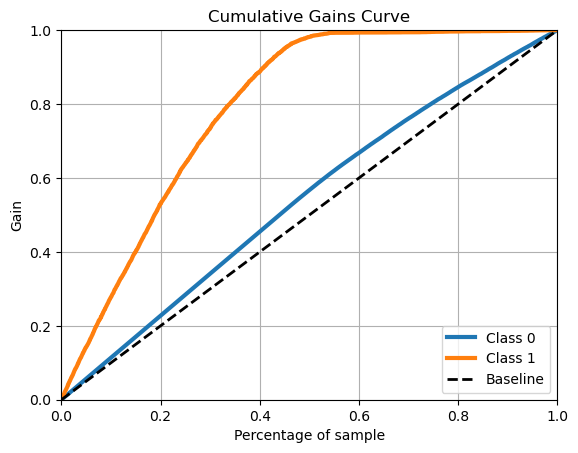

In [45]:
# modelo
rfc = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# treino
rfc.fit(x_train, y_train)

# predição
yhat_rfc = rfc.predict_proba(x_val)

# métricas
# copia do dataframe
data_rfc = x_val.copy()
data_rfc['response'] = y_val.copy()

# copia predicao
data_rfc['score'] = yhat_rfc[:, 1].tolist()

# ordenamento dos clientes pela predicao
data_rfc = data_rfc.sort_values('score', ascending=False)

f1, precision, recall = f1_at_k(data_rfc)
result_rfc = pd.DataFrame({'model': ['Random Forest Classifier'],
                           'Precision at 20000': precision,
                           'Recall at 20000': recall,
                           'F1-Score at 20000': f1})

# gráfico - ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_rfc);

result_rfc

### 7.3.1. Random Forest Classifier Cross-Validation

In [46]:
# modelo
rfc_model = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

f1_rfc, precision_rfc, recall_rfc = cross_validation(model=rfc_model, X=X, y=y)

result_rfc_cv = pd.DataFrame({'model': ['Random Forest Classifier'],
                           'Precision_CV at 20000': np.mean(precision_rfc),
                           'Recall_CV at 20000': np.mean(recall_rfc),
                           'F1-Score_CV at 20000': np.mean(f1_rfc)})
result_rfc_cv 

,model,Precision_CV at 20000,Recall_CV at 20000,F1-Score_CV at 20000
0,Random Forest Classifier,0.296,0.746,0.424


## 7.4. Extra Trees

,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,Extra Trees,0.267,0.897,0.412


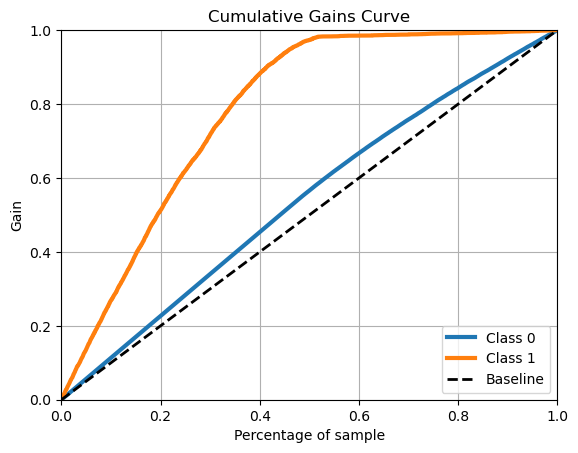

In [47]:
# modelo
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# treino
et.fit(x_train, y_train)

# predição
yhat_et = et.predict_proba(x_val)

# métricas
# copia do dataframe
data_et = x_val.copy()
data_et['response'] = y_val.copy()

# copia predicao
data_et['score'] = yhat_et[:, 1].tolist()

# ordenamento dos clientes pela predicao
data_et = data_et.sort_values('score', ascending=False)

f1, precision, recall = f1_at_k(data_et)
result_et = pd.DataFrame({'model': ['Extra Trees'],
                           'Precision at 20000': precision,
                           'Recall at 20000': recall,
                           'F1-Score at 20000': f1})

# gráfico - ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

result_et

### 7.4.1. Extra Trees Cross-Validation

In [48]:
# modelo
et_model = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

f1_et, precision_et, recall_et = cross_validation(model=et_model, X=X, y=y)

result_et_cv = pd.DataFrame({'model': ['Extra Trees'],
                           'Precision_CV at 20000': np.mean(precision_et),
                           'Recall_CV at 20000': np.mean(recall_et),
                           'F1-Score_CV at 20000': np.mean(f1_et)})
result_et_cv 

,model,Precision_CV at 20000,Recall_CV at 20000,F1-Score_CV at 20000
0,Extra Trees,0.291,0.734,0.417


## 7.5. XGBoost

,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,XGBoost,0.278,0.933,0.428


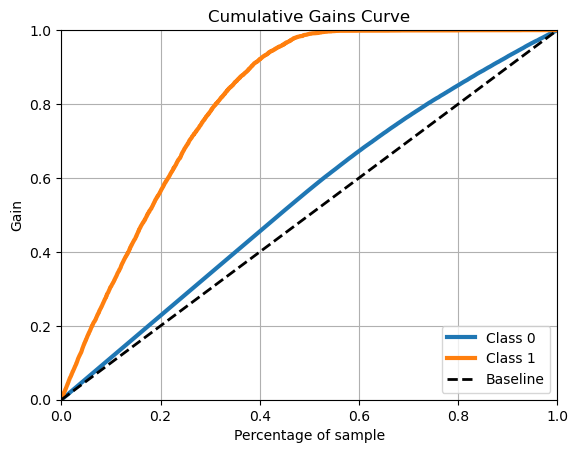

In [49]:
# modelo
xgboost = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# treino
xgboost.fit(x_train, y_train)

# predição
yhat_xgboost = xgboost.predict_proba(x_val)

# métricas
# copia do dataframe
data_xgb = x_val.copy()
data_xgb['response'] = y_val.copy()

# copia predicao
data_xgb['score'] = yhat_xgboost[:, 1].tolist()

# ordenamento dos clientes pela predicao
data_xgb = data_xgb.sort_values('score', ascending=False)

f1, precision, recall = f1_at_k(data_xgb)
result_xgb = pd.DataFrame({'model': ['XGBoost'],
                           'Precision at 20000': precision,
                           'Recall at 20000': recall,
                           'F1-Score at 20000': f1})

# gráfico - ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgboost);

result_xgb

### 7.5.1. XGBoost Cross-Validation

In [50]:
# modelo
xgboost_model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42)

f1_xgb, precision_xgb, recall_xgb = cross_validation(model=xgboost_model, X=X, y=y)

result_xgb_cv = pd.DataFrame({'model': ['XGBoost'],
                           'Precision_CV at 20000': np.mean(precision_xgb),
                           'Recall_CV at 20000': np.mean(recall_xgb),
                           'F1-Score_CV at 20000': np.mean(f1_xgb)})
result_xgb_cv 

,model,Precision_CV at 20000,Recall_CV at 20000,F1-Score_CV at 20000
0,XGBoost,0.315,0.794,0.451


## 7.6. Decision Tree

,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,Decision Tree,0.160,0.538,0.247


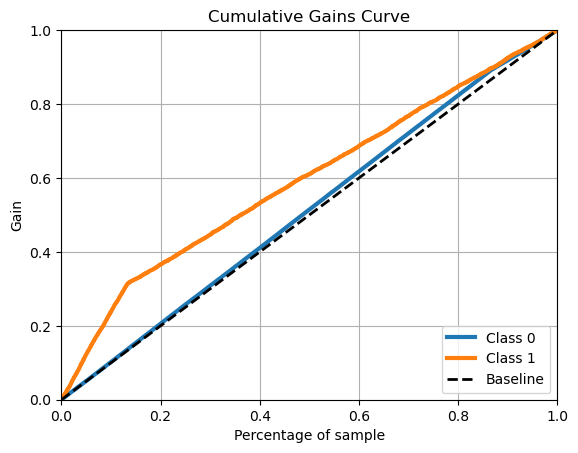

In [51]:
# modelo
dtc = DecisionTreeClassifier(random_state=42)

# treino
dtc.fit(x_train, y_train)

# predição
yhat_dtc = dtc.predict_proba(x_val)

# métricas
# copia do dataframe
data_dtc = x_val.copy()
data_dtc['response'] = y_val.copy()

# copia predicao
data_dtc['score'] = yhat_dtc[:, 1].tolist()

# ordenamento dos clientes pela predicao
data_dtc = data_dtc.sort_values('score', ascending=False)

f1, precision, recall = f1_at_k(data_dtc)
result_dtc = pd.DataFrame({'model': ['Decision Tree'],
                           'Precision at 20000': precision,
                           'Recall at 20000': recall,
                           'F1-Score at 20000': f1})

# gráfico - ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_dtc);

result_dtc

### 7.6.1. Decision Tree Cross-Validation

In [52]:
# modelo
dtc_model = DecisionTreeClassifier(random_state=42)

f1_dtc, precision_dtc, recall_dtc = cross_validation(model=dtc_model, X=X, y=y)

result_dtc_cv = pd.DataFrame({'model': ['Decision Tree'],
                           'Precision_CV at 20000': np.mean(precision_dtc),
                           'Recall_CV at 20000': np.mean(recall_dtc),
                           'F1-Score_CV at 20000': np.mean(f1_dtc)})
result_dtc_cv 

,model,Precision_CV at 20000,Recall_CV at 20000,F1-Score_CV at 20000
0,Decision Tree,0.178,0.448,0.255


## 7.7. Performance dos Modelos

In [53]:
result = pd.concat([result_knn, result_lr, result_rfc, result_et, result_xgb, result_dtc])
result_cv = pd.concat([result_knn_cv, result_lr_cv, result_rfc_cv, result_et_cv, result_xgb_cv, result_dtc_cv])

print("Sem Cross-Validation:")
display(result)

print("\nCom Cross-Validation:")
display(result_cv)

Sem Cross-Validation:


,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,KNN,0.261,0.876,0.402
0,Logistic Regression,0.264,0.887,0.407
0,Random Forest Classifier,0.269,0.904,0.415
0,Extra Trees,0.267,0.897,0.412
0,XGBoost,0.278,0.933,0.428
0,Decision Tree,0.160,0.538,0.247



Com Cross-Validation:


,model,Precision_CV at 20000,Recall_CV at 20000,F1-Score_CV at 20000
0,KNN,0.279,0.703,0.399
0,Logistic Regression,0.279,0.702,0.399
0,Random Forest Classifier,0.296,0.746,0.424
0,Extra Trees,0.291,0.734,0.417
0,XGBoost,0.315,0.794,0.451
0,Decision Tree,0.178,0.448,0.255


# 8.0. AJUSTE FINO DOS HIPERPARÂMETROS

Após análise dos resultados dos diferentes modelos de Machine Learning, utilizaremos o Random Forest para prosseguir com o projeto, apesar de não ter tido o melhor resultado, ainda sim teve um bom resultado em relação aos demais algoritmos.

## 8.1. Testando parâmetros

In [54]:
# param_space = {
#     'n_estimators': [50, 100, 200, 1000],
#     'max_features': ['auto', 'log2'],
#     'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

In [55]:
# rf_model = en.RandomForestClassifier() 

# random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_space, n_iter=5, scoring='precision', cv=5)

# random_search.fit(x_train, y_train)

# best_params = random_search.best_params_
# best_model = random_search.best_estimator_

# print("Melhores parâmetros encontrados:", best_params)
# print("Melhor precisão:", random_search.best_score_)

In [56]:
# rf_model = en.RandomForestClassifier() 

# random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_space, n_iter=10, scoring='f1', cv=5)

# random_search.fit(x_train, y_train)

# best_params = random_search.best_params_
# best_model = random_search.best_estimator_

## 8.2. Melhor Modelo Selecionado

In [57]:
# hiperparâmetros selecionados
param_tuned = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto',
               'max_depth': 10, 'bootstrap': False}

# melhor modelo de ML
rfc_model_tuned = en.RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2, n_estimators=100, 
                                            min_samples_split=2)

## 8.3. Modelo Final

In [78]:
x_test = x_test[cols_selected]

In [79]:
# treino
rfc_model_tuned.fit(X, y)

# predição
yhat_rfc_final = rfc_model_tuned.predict_proba(x_test)

# métricas
# copia do dataframe
data_rfc_tuned = x_test.copy()
data_rfc_tuned['response'] = y_test.copy()

# copia predicao
data_rfc_tuned['score'] = yhat_rfc_final[:, 1].tolist()

# ordenamento dos clientes pela predicao
data_rfc_tuned = data_rfc_tuned.sort_values('score', ascending=False)

f1, precision, recall = f1_at_k(data_rfc_tuned, k=20000)
result_rfc_final = pd.DataFrame({'model': ['Random Forest Classifier'],
                                 'Precision at 20000': precision,
                                 'Recall at 20000': recall,
                                 'F1-Score at 20000': f1})

display(result_rfc_final)

,model,Precision at 20000,Recall at 20000,F1-Score at 20000
0,Random Forest Classifier,0.302,0.863,0.448


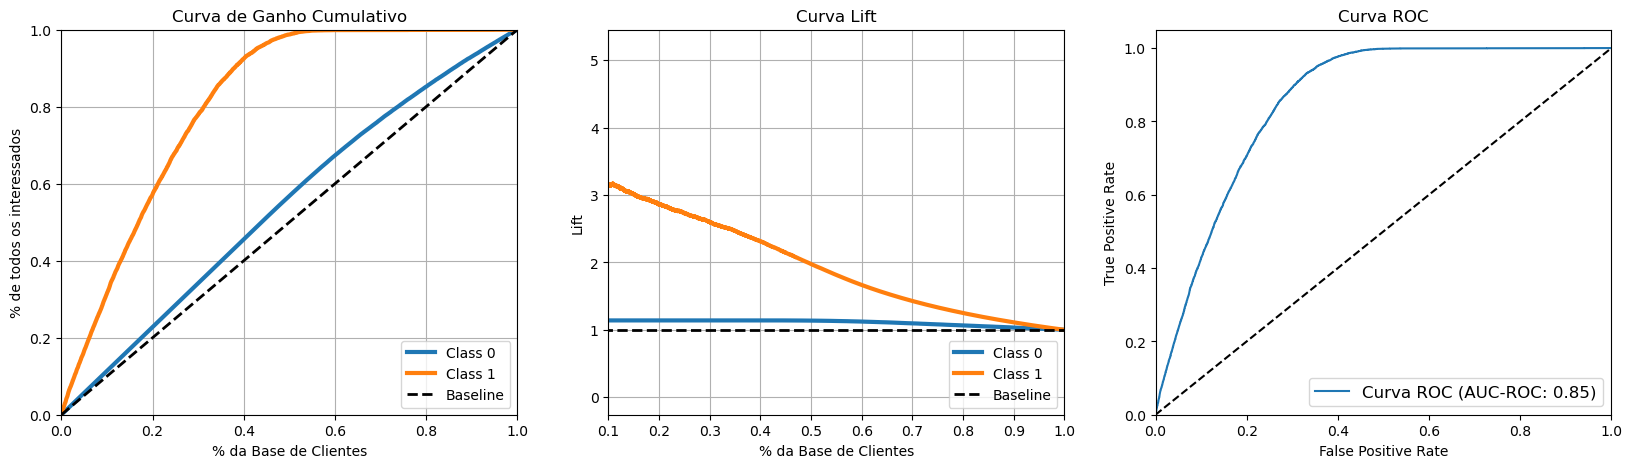

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# gráfico - ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test, yhat_rfc_final, ax=axs[0]);
axs[0].set_xlabel('% da Base de Clientes');
axs[0].set_ylabel('% de todos os interessados');
axs[0].set_title('Curva de Ganho Cumulativo');

# gráfico - curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_rfc_final, ax=axs[1]);
axs[1].set_xlim(0.1, 1.0);
axs[1].set_xlabel('% da Base de Clientes');
axs[1].set_title('Curva Lift');

# gráfico - curva ROC
fpr, tpr, thresholds = roc_curve(y_test, yhat_rfc_final[:, 1])
auc = auc_roc(y_test, yhat_rfc_final[:, 1]) # cálculo do AUC-ROC

axs[2].plot(fpr, tpr, label='Curva ROC (AUC-ROC: %0.2f)' % auc); # criando gráfico e adicionando AUC-ROC na legenda
axs[2].plot([0, 1], [0, 1], 'k--'); # criando linha pontilhada referente ao desempenho aleatório
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Curva ROC');
plt.legend(loc="lower right", fontsize=12);

# 9.0. RESPONDENDO AS PERGUNTAS DE NEGÓCIO

## 9.1. Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

**H1. Pessoas com mais de 30 anos têm mais interesse no seguro de carro.**<br>
Verdadeira. Vemos um aumento na quantidade de interessados e uma maior porcentagem de interessados por idade.

**H2. Pessoas que já têm seguro têm menos interesse no seguro oferecido.**<br>
Verdadeira. Quase nenhuma pessoa com seguro tem interesse no seguro oferecido.

**H3. Pessoas que já tiveram o carro danificado têm mais interesse no seguro.**<br>
Verdadeira. A grande maioria dos interessados teve o carro danificado.

**H9. Pessoas com carros mais novos têm mais interesse no seguro.**<br>
Falsa. Ao contrário, observa-se que quão mais velho o veículo, maior a taxa de interessados.

## 9.2. Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [83]:
_, precision, recall = f1_at_k(data_rfc_tuned, k=20000)
print(f'Das 20.000 ligações, {round(precision * 100, 1)}% dos clientes estarão interessados.')
print(f'Com 20.000 ligações o time de vendas conseguirá contatar {round(recall * 100, 1)}% do total de interessados.')

Das 20.000 ligações, 30.2% dos clientes estarão interessados.
Com 20.000 ligações o time de vendas conseguirá contatar 86.3% do total de interessados.


## 9.3. E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [84]:
_, precision, recall = f1_at_k(data_rfc_tuned, k=40000)
print(f'Das 40.000 ligações, {round(precision * 100, 1)}% dos clientes estarão interessados.')
print(f'Com 40.000 ligações o time de vendas conseguirá contatar {round(recall * 100, 1)}% do total de interessados.')

Das 40.000 ligações, 17.5% dos clientes estarão interessados.
Com 40.000 ligações o time de vendas conseguirá contatar 99.9% do total de interessados.


## 9.4. Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [85]:
df94 = pd.DataFrame()
df94['test'] = y_test.copy()
df94['pred'] = yhat_rfc_final[:, 1].tolist()

df94 = df94.sort_values('pred', ascending=False).reset_index(drop=True)

ligacoes = 0
encontrados = 0
meta = 0.8  # Porcentagem desejada de interessados encontrados
total_interessados = y_test.sum()

while encontrados / total_interessados < meta:
    # Contagem de interessados encontrados
    encontrados += 1 if (df94.loc[ligacoes, 'test'] == 1) else 0
    # Ligações efetuadas
    ligacoes += 1    

print(f'Para contatar 80% dos clientes interessados, o time de vendas precisará realizar {ligacoes} ligações.')

Para contatar 80% dos clientes interessados, o time de vendas precisará realizar 17877 ligações.


# 10.0. IMPLEMENTANDO MODELO EM PRODUÇÃO

Devido a limitação de espaço no Github, utilizaremos um modelo mais leve para predição dos dados.

In [86]:
pickle.dump(rfc_model_tuned, open('../webapp/model/RandomForestModel.pkl', 'wb'))

model_size = os.path.getsize('../webapp/model/RandomForestModel.pkl') / (1024**2)
print(f'Tamanho do modelo em megabytes: {round(model_size, 0)} MB')

Tamanho do modelo em megabytes: 7.0 MB


## 10.1. INSURANCE ALL CLASS

In [65]:
import pickle

import pandas as pd

# limpezas, transformações e encodes
class InsuranceAll(object):
    def __init__(self):
        self.standard_scaler_annual_premium = pickle.load( open('parameter/standard_scaler_annual_premium.pkl', 'rb'))
        self.min_max_scaler_age             = pickle.load(open('parameter/min_max_scaler_age.pkl', 'rb'))
        self.min_max_scaler_vintage         = pickle.load(open('parameter/min_max_scaler_vintage.pkl', 'rb'))
        self.target_encode_region_code      = pickle.load(open('parameter/target_encode_region_code.pkl', 'rb'))
        self.fe_policy_sales_channel        = pickle.load(open('parameter/fe_policy_sales_channel.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        # renomeando colunas
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 
                    'previously_insured', 'vehicle_age', 'vehicle_damage', 
                    'annual_premium', 'policy_sales_channel', 'vintage']
        
        df1.columns = cols_new
        
        return df1

    def feature_engineering(self, df2):
        # vehicle_age
        vehicle_age = {'< 1 Year': 'below_1_year', '1-2 Year': 'between_1_2_year', '> 2 Years': 'over_2_years'}
        df2['vehicle_age'] = df2['vehicle_age'].map(vehicle_age)
        
        return df2

    def data_preparation(self, df5):
        ## 5.1. Normalização
        # annual_premium
        df5['annual_premium'] = self.standard_scaler_annual_premium.transform(df5[['annual_premium']].values)

        ## 5.2. Redimensionando
        # age - MinMaxScaler
        df5['age'] = self.min_max_scaler_age.transform(df5[['age']].values)

        # vintage - MinMaxScaler
        df5['vintage'] = self.min_max_scaler_vintage.transform(df5[['vintage']].values)

        ## 5.3. Encoder
        # region_code - Target Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code)

        # policy_sales_channel - Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel)

        # vehicle_age - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'], dtype='int64')

        # vehicle_damage - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_damage', columns=['vehicle_damage'], dtype='int64')

        # gender - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='gender', columns=['gender'], dtype='int64')

        # colunas selecionadas
        cols_selected = ['age', 'region_code', 'previously_insured', 'annual_premium', 'policy_sales_channel', 
                         'vintage', 'vehicle_damage_No', 'vehicle_damage_Yes']
        
        # tratando o dataframe caso alguma coluna esteja ausente
        cols = []
        # separando as colunas ausentes
        for x in cols_selected:        
            if (x in df5.columns) == False:
                cols.append(x)        
        
        # adicionando colunas ausentes com valor 0
        if len(cols) != 0:
            for index, value in enumerate(cols):
                df5[value] = 0
        
        # fillna
        df5 = df5.fillna(0)
        
        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # modelo
        pred = model.predict_proba(test_data)
        
        # unir predição como dataset original
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API HANDLER

In [66]:
import os
import pickle

import pandas as pd

from flask                         import Flask, request, Response
from health_insurance.InsuranceAll import InsuranceAll

# carregando modelo
model = pickle.load(open('model/RandomForestModel.pkl', 'rb'))

app = Flask(__name__)

@app.route('/health_insurance/predict', methods=['POST'])
def health_insurance():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict): # exemplo único
            test_raw = pd.DataFrame(test_json, index=[0]) # converte json em dataframe
        else: # múltiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys()) # converte json em dataframe
        
        # instanciar classe InsuranceAll
        pipeline = InsuranceAll()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run(host='0.0.0.0', port=port)

ModuleNotFoundError: No module named 'health_insurance'

## 10.3. API TESTER

In [87]:
import requests

In [88]:
df10 = pd.read_csv('../datasets/test.csv')

In [89]:
# carregando dataset de treino
df_test = df10

In [90]:
df_test = df_test.head(50)

In [91]:
df_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.000,1,< 1 Year,No,35786.000,152.000,53
1,381111,Male,40,1,28.000,0,1-2 Year,Yes,33762.000,7.000,111
2,381112,Male,47,1,28.000,0,1-2 Year,Yes,40050.000,124.000,199
3,381113,Male,24,1,27.000,1,< 1 Year,Yes,37356.000,152.000,187
4,381114,Male,27,1,28.000,1,< 1 Year,No,59097.000,152.000,297
5,381115,Male,22,1,30.000,1,< 1 Year,No,40207.000,152.000,266
6,381116,Female,51,1,37.000,1,1-2 Year,No,40118.000,26.000,107
7,381117,Male,25,1,41.000,1,< 1 Year,No,23375.000,152.000,232
8,381118,Male,42,1,41.000,0,1-2 Year,Yes,2630.000,26.000,277
9,381119,Female,37,1,12.000,1,1-2 Year,No,27124.000,124.000,133


In [92]:
# convertendo dataframe em json
data = json.dumps(df_test.to_dict(orient='records'))

In [98]:
# Chamando a API
url = 'https://pa04-health-insurance-cross-sell.onrender.com/health_insurance/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [99]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
43,381153,Male,0.446,1,0.117,0,between_1_2_year,Yes,0.039,0.209,0.412,0.353
44,381154,Male,0.277,1,0.124,0,between_1_2_year,Yes,0.853,0.194,0.197,0.347
45,381155,Male,0.231,1,0.096,0,between_1_2_year,Yes,0.809,0.209,0.003,0.333
13,381123,Male,0.415,1,0.130,0,between_1_2_year,Yes,-0.106,0.194,0.042,0.327
40,381150,Female,0.385,1,0.187,0,between_1_2_year,Yes,0.341,0.194,0.087,0.321
2,381112,Male,0.415,1,0.187,0,between_1_2_year,Yes,0.552,0.194,0.654,0.316
1,381111,Male,0.308,1,0.187,0,between_1_2_year,Yes,0.186,0.004,0.349,0.315
41,381151,Male,0.400,1,0.187,0,between_1_2_year,Yes,4.653,0.026,0.671,0.314
8,381118,Male,0.338,1,0.120,0,between_1_2_year,Yes,-1.624,0.209,0.924,0.309
48,381158,Male,0.523,1,0.072,0,between_1_2_year,Yes,-0.418,0.028,0.716,0.278
